## HW2: Simple Spread Trading

The last digit of my student id is 7. 
Therefore i will be studying pairs of ETFs X:GII and Y:IGF 

GII: tracks SP Global Infrastructure (75 largest publicly listed infrastructure companies)

IGF: similar to GII, it tracks SP Global Infrastructure. The difference between those 2 funds rely on their expense ratio (fees), AUM, and liquidity


In [158]:
## Libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import quandl
import functools
import seaborn as sns
import os
import datetime
import matplotlib.dates as mdates
from dateutil.relativedelta import relativedelta


import plotnine as p9

API_key = 'CazLxm9XJ7CzL3g8prJm'
quandl.ApiConfig.api_key = API_key

#dates
start_date = '2022-12-02'
end_date = '2024-11-15'
date_list = pd.date_range(start=start_date, end=end_date).strftime("%Y-%m-%d").tolist()
tickers = ['SVOL', 'GII', 'IGF', 'SPY'] 

## Get data

We get the data from the publisher QUOTEMEDIA, we choose prices from this publisher because it contains end-of-day unadjusted stock prices, dividends, splits, and adjusted stock prices. History is available starting from 1996.

From this, we filter the list of tickers and the dates

We also import the FAMA-French data

We note that we add an ticker_list as an argument to avoid downloading all data

In [2]:
def grab_quandl_table(
    table_path,
    avoid_download=False,
    replace_existing=False,
    date_override=None,
    allow_old_file=False,
    **kwargs,
):
    root_data_dir = os.path.join(r"C:\Users\benja\OneDrive\Bureau\UchicagoMSFM\QTS" , "quandl_data_table_downloads")
    data_symlink = os.path.join(root_data_dir, f"{table_path}_latest.zip")
    if avoid_download and os.path.exists(data_symlink):
        print(f"Skipping any possible download of {table_path}")
        return data_symlink
    
    table_dir = os.path.dirname(data_symlink)
    if not os.path.isdir(table_dir):
        print(f'Creating new data dir {table_dir}')
        os.mkdir(table_dir)

    if date_override is None:
        my_date = datetime.datetime.now().strftime("%Y%m%d")
    else:
        my_date = date_override
    data_file = os.path.join(root_data_dir, f"{table_path}_{my_date}.zip")

    if os.path.exists(data_file):
        file_size = os.stat(data_file).st_size
        if replace_existing or not file_size > 0:
            print(f"Removing old file {data_file} size {file_size}")
        else:
            print(
                f"Data file {data_file} size {file_size} exists already, no need to download"
            )
            return data_file

    dl = quandl.export_table(
        table_path, filename=data_file, api_key=API_key, **kwargs
    )
    file_size = os.stat(data_file).st_size
    if os.path.exists(data_file) and file_size > 0:
        print(f"Download finished: {file_size} bytes")
        if not date_override:
            if os.path.exists(data_symlink):
                print(f"Removing old symlink")
                os.unlink(data_symlink)
            print(f"Creating symlink: {data_file} -> {data_symlink}")
            os.symlink(
                data_file, data_symlink,
            )
    else:
        print(f"Data file {data_file} failed download")
        return
    return data_symlink if (date_override is None or allow_old_file) else "NoFileAvailable"


def fetch_quandl_table(table_path, avoid_download=True, **kwargs):
    return pd.read_csv(
        grab_quandl_table(table_path, avoid_download=avoid_download, **kwargs)
    )

In [4]:
t_ivm = fetch_quandl_table('QUOTEMEDIA/PRICES', avoid_download=False, ticker=tickers, date = date_list)

col = ['date','ticker','adj_close','volume','split']
t_ivm['date'] = pd.to_datetime(t_ivm['date'])  # making sure date column is a datetime type
t_ivm = t_ivm.sort_values(by='date')[col]


Creating new data dir C:\Users\benja\OneDrive\Bureau\UchicagoMSFM\QTS\quandl_data_table_downloads\QUOTEMEDIA
Download finished: 73289 bytes
Creating symlink: C:\Users\benja\OneDrive\Bureau\UchicagoMSFM\QTS\quandl_data_table_downloads\QUOTEMEDIA/PRICES_20250123.zip -> C:\Users\benja\OneDrive\Bureau\UchicagoMSFM\QTS\quandl_data_table_downloads\QUOTEMEDIA/PRICES_latest.zip


In [5]:
file_path = r"C:\Users\benja\OneDrive\Bureau\UchicagoMSFM\QTS\quandl_data_table_downloads\FF_daily_data.CSV"

FF_df = pd.read_csv(file_path, skiprows=4) ## We skip the 4 first rows that correspond to the description of the data
FF_df = FF_df[:-1] ## We remove the last row that is a copyright 
FF_df.rename(columns={"Unnamed: 0": "Date"}, inplace=True)
FF_df['Date'] = pd.to_datetime(FF_df['Date'], format='%Y%m%d')
FF_df = FF_df[(start_date <= FF_df['Date']) & (FF_df['Date'] <= end_date)] ## We keep only the data between the start and end date
FF_df.head()

,Date,Mkt-RF,SMB,HML,RF
25379,2022-12-02,-0.08,0.92,-0.55,0.016
25380,2022-12-05,-2.02,-0.59,-0.52,0.016
25381,2022-12-06,-1.51,-0.24,1.15,0.016
25382,2022-12-07,-0.24,-0.13,-0.34,0.016
25383,2022-12-08,0.76,0.21,-1.22,0.016


## Separate dataframes + Add Features
Dataframe for SVOL, X data, Y data

Daily_dollar_volume : volume*adj_close

Compute the median of the past 15 trading-days prices

In [6]:
t_ivm['daily_dollar_volume'] = t_ivm['adj_close'] * t_ivm['volume']

# svol data
svol_df = t_ivm[t_ivm['ticker'] == 'SVOL'].copy()
# spread X
spread = t_ivm[t_ivm['ticker'] == 'GII'].merge(t_ivm[t_ivm['ticker'] == 'IGF'], on='date', suffixes=('_GII', '_IGF'))
spread['spread'] = spread['adj_close_GII'] - spread['adj_close_IGF']
spread['Nt_GII'] = spread['daily_dollar_volume_GII'].rolling(window=15).median()
spread['Nt_IGF'] = spread['daily_dollar_volume_IGF'].rolling(window=15).median()


## Analyse liquidity

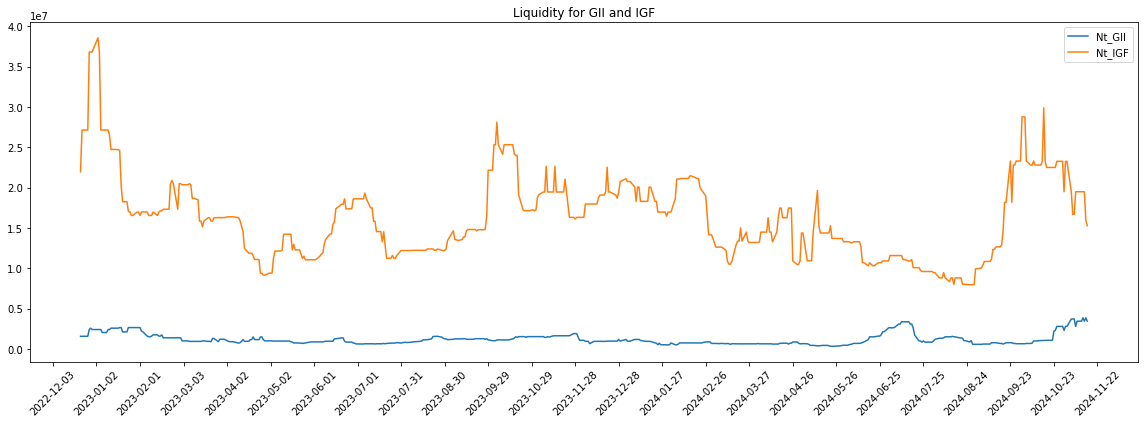

In [7]:
fig, ax = plt.subplots(1,1, figsize = (16,6))

ax.plot(spread['date'], spread['Nt_GII'], label='Nt_GII')
ax.plot(spread['date'], spread['Nt_IGF'], label='Nt_IGF')
ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format dates
ax.xaxis.set_major_locator(mdates.DayLocator(interval=30))       # Tick every 5 days (adjust as needed)
ax.tick_params(axis = 'x',rotation=45) 
ax.set_title('Liquidity for GII and IGF')

plt.tight_layout()
plt.show()

We can see that there is an ETF that is clearly more liquid than the other.

We can see that $\textbf{IGF is clearly more liquid than GII ETF}$ (which makes sense because IGF is a Blackrock ETF that is way more well-known than GII)


Therefore, I will use GII ETF for the value of Nt for spread-trading strategy

The idea is that when I will trade a spread, I will be trading both IGF and GII. Therefore, as we want to avoid excessif exposure wrt to the liquidity, we have to scale on the least liquid asset.

In [8]:
## Set the liquidity to the spread data
spread['Nt'] = spread['Nt_GII']

## Analyse Spread trends

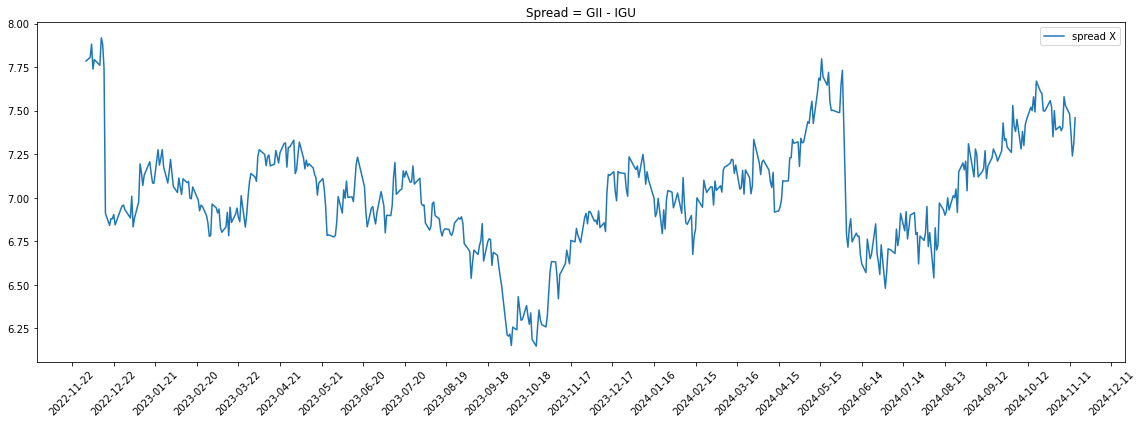

In [9]:
fig, ax = plt.subplots(1,1, figsize = (16,6))

ax.plot(spread['date'], spread['spread'], label='spread X')
ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Format dates
ax.xaxis.set_major_locator(mdates.DayLocator(interval=30))       # Tick every 5 days (adjust as needed)
ax.tick_params(axis = 'x',rotation=45) 
ax.set_title('Spread = GII - IGU')


plt.tight_layout()
plt.show()

$\textbf{Spread Analysis:}  \\$

We can see that the spread is mean-reverting which is a good behavior for a mean-reverting strategy (we can assume that if the spread of prices revert, the spread of returns should possibly do as well)

## Spread-Reversion Trading

Start trade after January first 2023 and close all position for the closing of day 2024 November 25th.

In my strategy I have to trade equal-sized dollar amount (to the nearest integer nb of shares) of the product X and product Y, as close as possible to Nt/100 $\Rightarrow$ I have around 2Nt/100 \$ traded overall

Let $$ z = r_x^M -r_y^M$$
be the difference of M-days returns between spread X and Y.\\

The strategy is:

 
\begin{cases} 
    \text{long spread (= X-Y) == buy GII and short IGF, if z<-g} \\
    \text{exit position, if -j<z<j}  \\
    \text{short spread (= X-Y) == buy IGF and short GII, if z>g}
\end{cases}

$\underline{\text{Important to note}}$

If we were long spread (we had z<-g) and the next day we have a short spread signal (i.e z>g), then we have first to exit our position (i.e sell the shares we had and buy the shares we were shorting) and then enter the short position with the newly calculated number of shares.

Similarly if we were short spread and the next day we have long spread signal



In [10]:
spread.head()

,date,ticker_GII,adj_close_GII,volume_GII,split_GII,daily_dollar_volume_GII,ticker_IGF,adj_close_IGF,volume_IGF,split_IGF,daily_dollar_volume_IGF,spread,Nt_GII,Nt_IGF,Nt
0,2022-12-02,GII,52.763781,5084.0,1.0,2.682511e+05,IGF,44.978556,460478.0,1.0,2.071164e+07,7.785225,NaN,NaN,NaN
1,2022-12-05,GII,52.089422,32806.0,1.0,1.708846e+06,IGF,44.282818,965678.0,1.0,4.276294e+07,7.806604,NaN,NaN,NaN
2,2022-12-06,GII,52.118323,30036.0,1.0,1.565426e+06,IGF,44.235808,496605.0,1.0,2.196772e+07,7.882514,NaN,NaN,NaN
3,2022-12-07,GII,52.002718,25413.0,1.0,1.321545e+06,IGF,44.264014,452291.0,1.0,2.002022e+07,7.738704,NaN,NaN,NaN
4,2022-12-08,GII,52.310997,92441.0,1.0,4.835681e+06,IGF,44.517865,448038.0,1.0,1.994569e+07,7.793132,NaN,NaN,NaN


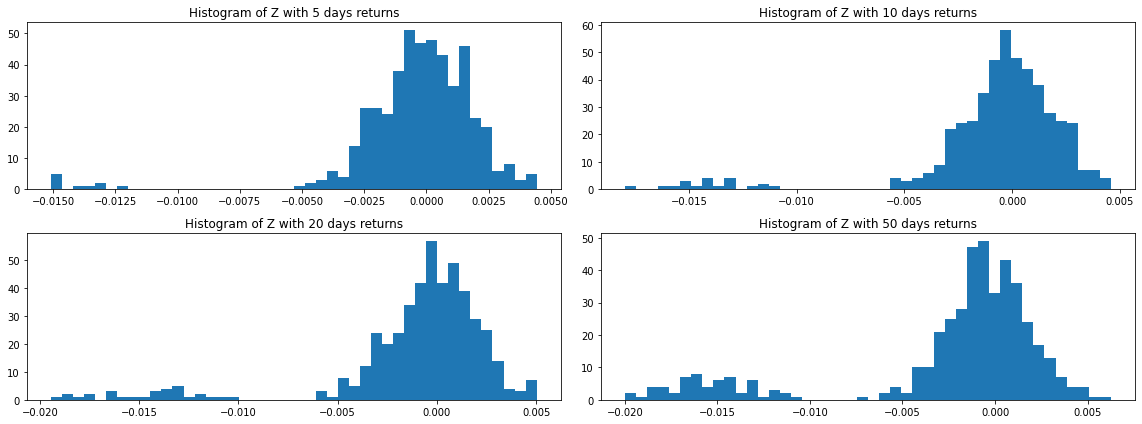

,M_days_return_5,M_days_return_10,M_days_return_20,M_days_return_50
count,487.000000,482.000000,472.000000,442.000000
mean,-0.000336,-0.000659,-0.001042,-0.002367
std,0.002617,0.003345,0.004085,0.005590
min,-0.015089,-0.017960,-0.019445,-0.019981
25%,-0.001237,-0.001461,-0.001833,-0.002644
50%,-0.000093,-0.000189,-0.000297,-0.000701
75%,0.001171,0.001149,0.001170,0.000806
max,0.004433,0.004578,0.005027,0.006247


In [11]:
## 1st let analyze the value for Z to determine the optimal values for the signal parameters
fig, axes = plt.subplots(2,2, figsize = (16,6))

df_copy = spread.copy()
df_copy['GII_returns_5'] = (1+df_copy['adj_close_GII'].pct_change()).rolling(window=5).apply(lambda x: np.prod(x), raw=True)
df_copy['GII_returns_10'] = (1+df_copy['adj_close_GII'].pct_change()).rolling(window=10).apply(lambda x: np.prod(x), raw=True)
df_copy['GII_returns_20'] = (1+df_copy['adj_close_GII'].pct_change()).rolling(window=20).apply(lambda x: np.prod(x), raw=True)
df_copy['GII_returns_50'] = (1+df_copy['adj_close_GII'].pct_change()).rolling(window=50).apply(lambda x: np.prod(x), raw=True)

df_copy['IGF_returns_5'] = (1+df_copy['adj_close_IGF'].pct_change()).rolling(window=5).apply(lambda x: np.prod(x), raw=True)
df_copy['IGF_returns_10'] = (1+df_copy['adj_close_IGF'].pct_change()).rolling(window=10).apply(lambda x: np.prod(x), raw=True)
df_copy['IGF_returns_20'] = (1+df_copy['adj_close_IGF'].pct_change()).rolling(window=20).apply(lambda x: np.prod(x), raw=True)
df_copy['IGF_returns_50'] = (1+df_copy['adj_close_IGF'].pct_change()).rolling(window=50).apply(lambda x: np.prod(x), raw=True)

z = pd.DataFrame(columns=['M_days_return', 'M_days_return_5', 'M_days_return_10', 'M_days_return_15', 'M_days_return_20'])
z['M_days_return_5'] = df_copy['GII_returns_5'] - df_copy['IGF_returns_5']
z['M_days_return_10'] = df_copy['GII_returns_10'] - df_copy['IGF_returns_10']
z['M_days_return_20'] = df_copy['GII_returns_20']- df_copy['IGF_returns_20']
z['M_days_return_50'] = df_copy['GII_returns_50'] - df_copy['IGF_returns_50']

n_bins = 2*int(np.sqrt(len(z)))
axes[0,0].hist(z['M_days_return_5'], bins=n_bins)
axes[0,0].set_title('Histogram of Z with 5 days returns')
axes[0,1].hist(z['M_days_return_10'], bins=n_bins)
axes[0,1].set_title('Histogram of Z with 10 days returns')
axes[1,0].hist(z['M_days_return_20'], bins=n_bins)
axes[1,0].set_title('Histogram of Z with 20 days returns')
axes[1,1].hist(z['M_days_return_50'], bins=n_bins)
axes[1,1].set_title('Histogram of Z with 50 days returns')
plt.tight_layout()
plt.show() 

z.describe()

We can see that as we increase M (number of lagged days), the standard deviation increases and the mean become lower (more negative). $\textbf{We also see extreme negative values of z having a higher probability as M increases}$. This means that to choose g and j, we need to take into account these means and std. We could define:
$$
g = mean + 3*std 
$$

$$
j = mean + 1*std 
$$

## Backtesting strategy

When we have new data coming, the strategy/position we take depends on wether we were long, short or neutral the previous day.

We have a funtion get_market_value_portoflio(). This function evaluate the value of the asset we hold = curr_shares_X*new_price_x + curr_shares_Y*new_price_Y. This function also give the profit we make from exiting a position

The (realised) PNL is the profit or loss earned after closing a position

The Unrealised PNL reflects the potential profit or loss from an open position

In [57]:
class backtest:
    def __init__(self, spread, svol_df, FF_df, start_trading_date, end_trading_date, M, g, j, s, trading_cost):
        self.K = 2*max(spread['Nt'].dropna()) ## initial capital is twice the maximum liquidity
        self.initial_capital = self.K
        # print('Initial capital:', self.K)
        self.ksi = trading_cost
        self.GT = np.inf ## gross traded cash at last trade
        self.last_trade_value = 0
        self.s = s ## stop loss barrier coefficient
        self.stop_loss_days= 21 ## days after we hit stop loss barrier
        self.df = spread.copy()
        self.df['GII_M_days_return'] = (1+self.df['adj_close_GII'].pct_change()).rolling(window=M).apply(lambda x: np.prod(x), raw=True)
        self.df['IGF_M_days_return'] = (1+self.df['adj_close_IGF'].pct_change()).rolling(window=M).apply(lambda x: np.prod(x), raw=True)
        self.df = self.df[self.df['date'] >= start_trading_date]
        self.df.reset_index(drop=True, inplace=True)
        self.df['z'] = self.df['GII_M_days_return'] - self.df['IGF_M_days_return']
        self.svol_df = svol_df
        self.FF_df = FF_df
        
        self.index = 0
        self.end_date = self.df[self.df['date'] <= end_trading_date]['date'].values[-1]
        self.end_index = self.df[self.df['date'] == self.end_date].index[0]
        
        self.M = M   ## M-days return
        self.g = g   ## buy signal
        self.j = j   ## sell signal
        
        # track portfolio performance
        self.portfolio = pd.DataFrame(columns=['date', 'capital', 'signal', 'X_shares', 'Y_shares', 'value_portfolio','pnl', 'u_pnl'])
        self.portfolio['date'] = self.df['date']
        self.portfolio['capital'] = self.K
        self.portfolio['value_portfolio'] = self.K
        self.portfolio['X_shares'] = 0  
        self.portfolio['Y_shares'] = 0
        self.portfolio['pnl'] = .0
        self.portfolio['u_pnl'] = .0
        self.portfolio['z'] = self.df['z']
        
    def get_z_value(self, index):
        return self.df.loc[index,'z']
    
    
    def get_stop_loss_recovery_period(self, date):
        today = date #datetime.datetime.strptime(date, "%Y-%m-%d")
        next_month = today + relativedelta(months=1)
        return [(today+relativedelta(days=x)).strftime("%Y-%m-%d") for x in range(1, (next_month.replace(day=1)-today).days)]
        
    def get_volume_trade(self, index):
        dollar_amount = self.df.loc[index,'Nt']/100
        nb_shares_X = np.round(dollar_amount/self.df.iloc[index]['adj_close_GII']) 
        nb_shares_Y = np.round(dollar_amount/self.df.iloc[index]['adj_close_IGF'])
        return nb_shares_X, nb_shares_Y
    
    def get_market_value_portfolio(self, index):
        nb_shares_X = self.portfolio.loc[index-1,'X_shares']
        nb_shares_Y = self.portfolio.loc[index-1,'Y_shares']
        market_value = nb_shares_X*self.df.loc[index,'adj_close_GII'] + nb_shares_Y*self.df.loc[index, 'adj_close_IGF']
        return market_value
    
    def trading_cost(self, index, Nx, Ny):
        tc = self.ksi*(abs(Nx*self.df.loc[index,'adj_close_GII']) + abs(Ny*self.df.loc[index,'adj_close_IGF']))
        return tc
    
    def close_positions(self, index):
        exit_profit = self.get_market_value_portfolio(index)
        curr_nb_shares_X = self.portfolio.loc[index-1,'X_shares']
        curr_nb_shares_Y = self.portfolio.loc[index-1,'Y_shares']
        tc = self.trading_cost(index, curr_nb_shares_X, curr_nb_shares_Y)
        self.K += exit_profit - tc ## we the profit to the capital and we remove the trading cost
        self.portfolio.loc[index, 'capital']  = self.K
        self.portfolio.loc[index, 'X_shares'] = 0
        self.portfolio.loc[index, 'Y_shares'] = 0
        self.portfolio.loc[index, 'value_portfolio'] = self.K  
        self.GT = np.inf
        realised_pnl = exit_profit - self.last_trade_value - tc
        self.portfolio.loc[index, 'pnl'] = realised_pnl
        return 0
    
    def open_short_position(self, index):
        new_nb_shares_X, new_nb_shares_Y = self.get_volume_trade(index)
        ## We sell X-Y -tc
        spread_value = new_nb_shares_X*self.df.loc[index,'adj_close_GII'] - new_nb_shares_Y*self.df.loc[index,'adj_close_IGF']
        tc = self.trading_cost(index, new_nb_shares_X, new_nb_shares_Y)
        self.last_trade_value = -spread_value - tc
        self.GT = new_nb_shares_X*self.df.loc[index,'adj_close_GII'] + new_nb_shares_Y*self.df.loc[index,'adj_close_IGF']
        self.portfolio.loc[index, 'value_portfolio'] = self.K - tc ## the value of portfolio does not change except for the trading cost
        self.K += spread_value - tc
        self.portfolio.loc[index, 'capital']  = self.K
        self.portfolio.loc[index, 'X_shares'] = - new_nb_shares_X
        self.portfolio.loc[index, 'Y_shares'] = new_nb_shares_Y
        signal = -1
        return signal
    
    def open_long_position(self, index):
        new_nb_shares_X, new_nb_shares_Y = self.get_volume_trade(index)
        ## we buy X-Y
        spread_value = new_nb_shares_X*self.df.loc[index,'adj_close_GII'] - new_nb_shares_Y*self.df.loc[index,'adj_close_IGF']
        tc = self.trading_cost(index, new_nb_shares_X, new_nb_shares_Y)
        self.last_trade_value = spread_value + tc
        self.portfolio.loc[index, 'value_portfolio'] = self.K - tc ## the value of portfolio does not change except for the trading cost
        self.K = self.K -spread_value - tc
        self.portfolio.loc[index, 'capital']  = self.K
        self.portfolio.loc[index, 'X_shares'] = new_nb_shares_X
        self.portfolio.loc[index, 'Y_shares'] = - new_nb_shares_Y
        signal = 1
        return signal
    
    def no_new_position(self, index, prev_signal):
        self.portfolio.loc[index, 'capital']  = self.K
        if index == 0:
            self.portfolio.loc[index, 'X_shares'] = 0
            self.portfolio.loc[index, 'Y_shares'] = 0
            market_value = 0
        else:
            self.portfolio.loc[index, 'X_shares'] = self.portfolio.loc[index-1,'X_shares']
            self.portfolio.loc[index, 'Y_shares'] = self.portfolio.loc[index-1,'Y_shares']
            market_value = self.get_market_value_portfolio(index)
        self.portfolio.loc[index, 'value_portfolio'] = self.K + market_value
        self.portfolio.loc[index, 'u_pnl'] = market_value - self.last_trade_value 
        if market_value - self.last_trade_value < - self.s * self.GT:  ## we hit the stop loss barrier
            self.close_positions(index)
            self.portfolio.loc[index, 'signal'] = 0
            stop_loss_date = self.get_stop_loss_recovery_period(self.df.loc[index,'date'])[-1]
            stop_loss_index = self.df[self.df['date'] >= stop_loss_date].index[0]
            while self.index < self.end_index and self.index < stop_loss_index:
                self.index += 1
                self.portfolio.iloc[self.index] = self.portfolio.iloc[self.index-1]
                print('we are at date', self.df.loc[self.index,'date'],' and come back after', self.df.loc[stop_loss_index,'date'])
            
        return prev_signal
    
    def get_signal_from_0(self, index, z): ## we had no position
        if z > self.g: ##  go short: sell GII and buy IGF 
            signal = self.open_short_position(index)
            
        elif z < - self.g: ## go long: buy GII and sell IGF
            signal = self.open_long_position(index)
            
        else: ## do not take position
            signal = self.no_new_position(index, prev_signal=0)
        return signal
    
    def get_signal_from_minus_1(self, index, z): ## we had a short position (overpriced GII and underpriced IGF)
        if z > self.j: ## keep short position
            signal = self.no_new_position(index, prev_signal=-1)
                    
        elif z <- self.g: ## close short position (i.e buy GII we shorted and sell IGF we bought) and open long position (buy GII and sell  UGF with new nb shares) 
            self.close_positions(index) ## we close the short position, transaction cost is already included
            signal = self.open_long_position(index)
        else: ## close long position
            signal = self.close_positions(index)
        return signal
    
    def get_signal_from_1(self, index, z): ## we had a long position

        if z < - self.j: ## keep long position
            signal = self.no_new_position(index, prev_signal=1)
                
        elif z > self.g: ## close long position and open short position: sell (curr_shares_X + new_shares_x) GII and buy (curr_shares_Y + new_shares_Y) of IGF 
            self.close_positions(index) ## we close the long position, th portoflio is updated and transaction cost is already included
            signal = self.open_short_position(index)
        else: ## close long position
            signal = self.close_positions(index)
        return signal
    
    
    def apply_position(self, index):
        if index == self.end_index:
            self.close_positions(index)
        
        elif index == 0:
            z = self.get_z_value(index)
            signal = self.get_signal_from_0(index, z)
            self.portfolio.loc[index, 'signal'] = signal
            
        else:
            z = self.get_z_value(index)
            prev_signal = self.portfolio.loc[index-1, 'signal']
            if np.isnan(prev_signal):
                raise ValueError('Previous signal is NaN')
            
            if np.isnan(z):
                print('NaN value for z: keep the position and pass')
                signal = self.no_new_position(index)
                self.portfolio.loc[index, 'signal'] = signal
                
            else:
                if prev_signal == 0: # we had no position
                    signal = self.get_signal_from_0(index, z)
                        
                if prev_signal == 1: # we had a long position (i.e short GII and long IGF)
                    signal = self.get_signal_from_1(index, z)

                if prev_signal == -1: # we had a short position (we were long GII and short IGF)
                    signal = self.get_signal_from_minus_1(index, z)
            self.portfolio.loc[index, 'signal'] = signal
        
        
            
    def run(self):
        while self.index <= self.end_index:
            self.apply_position(self.index)
            self.index += 1
        return self.portfolio['value_portfolio'].iloc[-1]

## Comparing strategy with and without transaction costs

In [125]:
## Setup backtest

start_trading_date = '2023-01-01'
end_trading_date = '2024-11-15'

M1, g1, j1, s1, tc1 = 10, 0.002, 0.001, 0.1, 0
M2, g2, j2, s2, tc2 = 10, 0.002, 0.001, 0.1, 0.00001


strategy1 = backtest(spread, svol_df, FF_df, start_trading_date, end_trading_date, M1, g1, j1,s1, tc1)
strategy2 = backtest(spread, svol_df, FF_df, start_trading_date, end_trading_date, M2, g2, j2,s2, tc2)

In [126]:
strategy1.run()
strategy2.run()

7705697.917377701

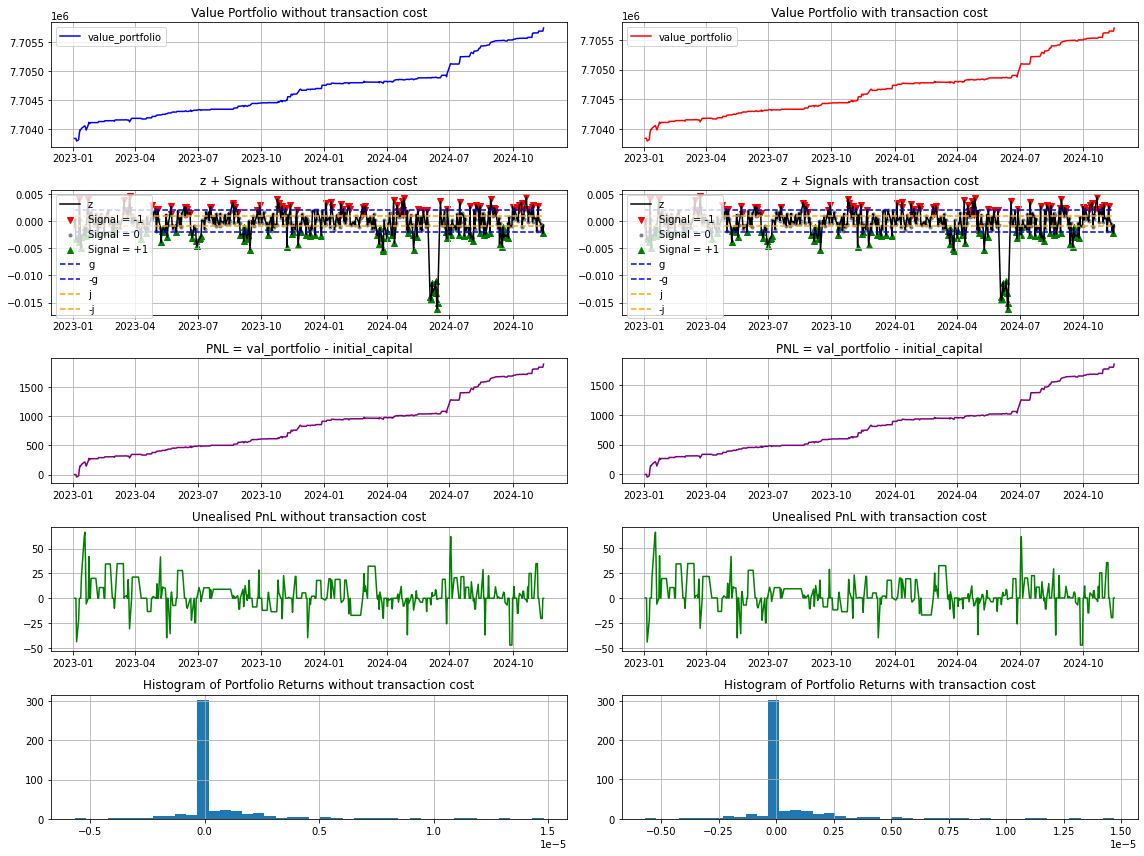

In [127]:

# 1) Filter by signals
df_minus1_1 = strategy1.portfolio[strategy1.portfolio['signal'] == -1]
df_zero_1   = strategy1.portfolio[strategy1.portfolio['signal'] == 0]
df_plus1_1  = strategy1.portfolio[strategy1.portfolio['signal'] == 1]
strategy1.portfolio['cumulative_pnl'] = strategy1.portfolio['pnl'].cumsum()

df_minus1_2 = strategy2.portfolio[strategy2.portfolio['signal'] == -1]
df_zero_2   = strategy2.portfolio[strategy2.portfolio['signal'] == 0]
df_plus1_2  = strategy2.portfolio[strategy2.portfolio['signal'] == 1]
strategy2.portfolio['cumulative_pnl'] = strategy2.portfolio['pnl'].cumsum()

fig, ax = plt.subplots(5, 2, figsize=(16, 12))  # 4 rows, 2 columns

############################################
# Plot 1 and 2: Value Portfolio
############################################
ax[0, 0].plot(strategy1.portfolio['date'], strategy1.portfolio['value_portfolio'], label='value_portfolio', color='blue')
ax[0, 0].legend()
ax[0, 0].set_title('Value Portfolio without transaction cost')
ax[0, 0].grid(True)

ax[0, 1].plot(strategy2.portfolio['date'], strategy2.portfolio['value_portfolio'], label='value_portfolio', color='red')
ax[0, 1].legend()
ax[0, 1].set_title('Value Portfolio with transaction cost')
ax[0, 1].grid(True)
############################################
# Plot 3 and 4: z + scatter signals
############################################
ax[1, 0].plot(strategy1.portfolio['date'], strategy1.portfolio['z'], label='z', color='black')
# scatter signals
ax[1, 0].scatter(df_minus1_1['date'], df_minus1_1['z'], marker='v', color='red', label='Signal = -1')
ax[1, 0].scatter(df_zero_1['date'], df_zero_1['z'], marker='.', color='grey', label='Signal = 0')
ax[1, 0].scatter(df_plus1_1['date'], df_plus1_1['z'], marker='^', color='green', label='Signal = +1')
# lines for g, -g, j, -j
ax[1, 0].plot(strategy1.portfolio['date'], g1*np.ones(len(strategy1.portfolio)), label='g', color='blue', linestyle='--')
ax[1, 0].plot(strategy1.portfolio['date'], -g1*np.ones(len(strategy1.portfolio)), label='-g', color='blue', linestyle='--')
ax[1, 0].plot(strategy1.portfolio['date'], j1*np.ones(len(strategy1.portfolio)), label='j', color='orange', linestyle='--')
ax[1, 0].plot(strategy1.portfolio['date'], -j1*np.ones(len(strategy1.portfolio)), label='-j', color='orange', linestyle='--')
ax[1, 0].legend()
ax[1, 0].set_title('z + Signals without transaction cost')
ax[1, 0].grid(True)

ax[1, 1].plot(strategy2.portfolio['date'], strategy2.portfolio['z'], label='z', color='black')
# scatter signals
ax[1, 1].scatter(df_minus1_2['date'], df_minus1_2['z'], marker='v', color='red', label='Signal = -1')
ax[1, 1].scatter(df_zero_2['date'], df_zero_2['z'], marker='.', color='grey', label='Signal = 0')
ax[1, 1].scatter(df_plus1_2['date'], df_plus1_2['z'], marker='^', color='green', label='Signal = +1')
# lines for g, -g, j, -j
ax[1, 1].plot(strategy2.portfolio['date'], g2*np.ones(len(strategy2.portfolio)), label='g', color='blue', linestyle='--')
ax[1, 1].plot(strategy2.portfolio['date'], -g2*np.ones(len(strategy2.portfolio)), label='-g', color='blue', linestyle='--')
ax[1, 1].plot(strategy2.portfolio['date'], j2*np.ones(len(strategy2.portfolio)), label='j', color='orange', linestyle='--')
ax[1, 1].plot(strategy2.portfolio['date'], -j2*np.ones(len(strategy2.portfolio)), label='-j', color='orange', linestyle='--')
ax[1, 1].legend()
ax[1, 1].set_title('z + Signals with transaction cost')
ax[1, 1].grid(True)

############################################
# Plot 5 and 6: PNL
############################################
ax[2, 0].plot(strategy1.portfolio['date'], strategy1.portfolio['value_portfolio'] - strategy1.initial_capital, label='signal', color='purple')
ax[2, 0].set_title('PNL = val_portfolio - initial_capital')
ax[2, 0].grid(True)

ax[2, 1].plot(strategy2.portfolio['date'], strategy2.portfolio['value_portfolio'] - strategy2.initial_capital, label='signal', color='purple')
ax[2, 1].set_title('PNL = val_portfolio - initial_capital')
ax[2, 1].grid(True)

############################################
# Plot 7 and 8: Unrealised PNL
############################################
ax[3, 0].plot(
    strategy1.portfolio['date'],
    strategy1.portfolio['u_pnl'],
    label='Unrealised pnl',
    color='green'
)
ax[3, 0].set_title('Unealised PnL without transaction cost')
ax[3, 0].grid(True)

ax[3, 1].plot(
    strategy2.portfolio['date'],
    strategy2.portfolio['u_pnl'],
    label='Unrealised pnl',
    color='green'
)
ax[3, 1].set_title('Unealised PnL with transaction cost')
ax[3, 1].grid(True)

############################################
# Plot  and 8: Portfolio Return Histogram
############################################

n_bins = 2*int(np.sqrt(len(strategy1.portfolio)))
returns1 = strategy1.portfolio['value_portfolio'].pct_change().dropna()
returns2 = strategy2.portfolio['value_portfolio'].pct_change().dropna()
ax[4, 0].hist(returns1, bins=n_bins)
ax[4, 0].set_title('Histogram of Portfolio Returns without transaction cost')
ax[4, 0].grid(True)

ax[4, 1].hist(returns2, bins=n_bins)
ax[4, 1].set_title('Histogram of Portfolio Returns with transaction cost')
ax[4, 1].grid(True)

plt.tight_layout()
plt.show()



In [128]:
print('What we lost with transaction cost:', strategy1.portfolio['value_portfolio'].iloc[-1] - strategy2.portfolio['value_portfolio'].iloc[-1])

What we lost with transaction cost: 46.83819539658725


## Commentary

We can see that we have a profitable trading strategy (we made around 2000$). With transaction cost we loose around 50$ (which seems realistic)

The graph representing the signal is a good demonstration of our spread trading strategy: a mean reversion trading strategy on the spread. It demonstrate well that we have almost no loosing trade (since the value of z always reverts) 

The historgrams on returns shows we have a right tail distribution of returns (which makes sense with the PNL value we end with). Also there is no extreme loss (because always revert to the mean) but we have few high profits (the drops in the Z graph)

## Checking if the stop loss works correctly

When we hit the stop loss barrier we do not trade until the end of the month.

Since our z values remains quite low, we must set a very s = 0.01% to see if it behaves as we expect, and how the portfolio goes with that


In [129]:
M3, g3, j3, s3, tc3 = 10, 0.002, 0.001, 0.0001, 0
strategy3 = backtest(spread, svol_df, FF_df, start_trading_date, end_trading_date, M3, g3, j3,s3, tc3)
strategy3.run()

we are at date 2023-03-27 00:00:00  and come back after 2023-03-31 00:00:00
we are at date 2023-03-28 00:00:00  and come back after 2023-03-31 00:00:00
we are at date 2023-03-29 00:00:00  and come back after 2023-03-31 00:00:00
we are at date 2023-03-30 00:00:00  and come back after 2023-03-31 00:00:00
we are at date 2023-03-31 00:00:00  and come back after 2023-03-31 00:00:00
we are at date 2023-06-16 00:00:00  and come back after 2023-06-30 00:00:00
we are at date 2023-06-20 00:00:00  and come back after 2023-06-30 00:00:00
we are at date 2023-06-21 00:00:00  and come back after 2023-06-30 00:00:00
we are at date 2023-06-22 00:00:00  and come back after 2023-06-30 00:00:00
we are at date 2023-06-23 00:00:00  and come back after 2023-06-30 00:00:00
we are at date 2023-06-26 00:00:00  and come back after 2023-06-30 00:00:00
we are at date 2023-06-27 00:00:00  and come back after 2023-06-30 00:00:00
we are at date 2023-06-28 00:00:00  and come back after 2023-06-30 00:00:00
we are at da

7705303.367729988

we can see that the non-trading rule is well-respected

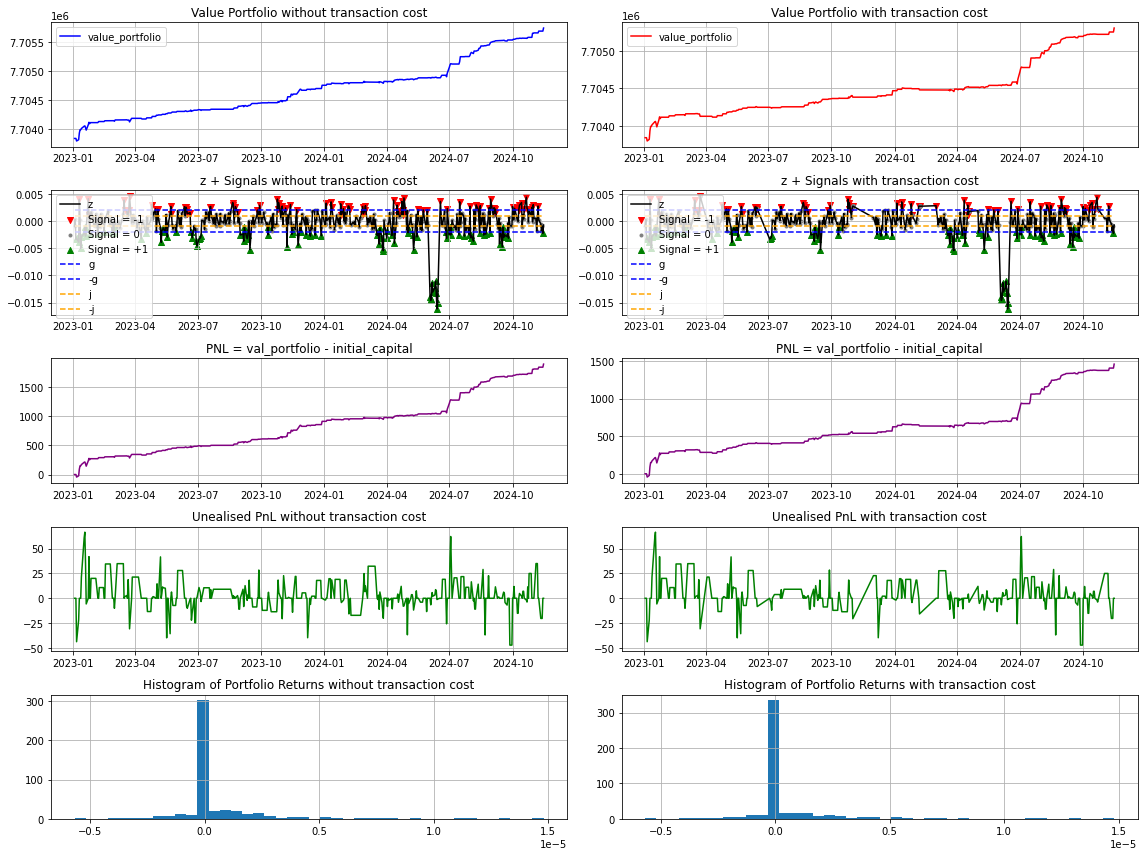

In [130]:
# 1) Filter by signals
df_minus1_1 = strategy1.portfolio[strategy1.portfolio['signal'] == -1]
df_zero_1   = strategy1.portfolio[strategy1.portfolio['signal'] == 0]
df_plus1_1  = strategy1.portfolio[strategy1.portfolio['signal'] == 1]
strategy1.portfolio['cumulative_pnl'] = strategy1.portfolio['pnl'].cumsum()

df_minus1_3 = strategy3.portfolio[strategy3.portfolio['signal'] == -1]
df_zero_3 = strategy3.portfolio[strategy3.portfolio['signal'] == 0]
df_plus1_3  = strategy3.portfolio[strategy3.portfolio['signal'] == 1]
strategy3.portfolio['cumulative_pnl'] = strategy3.portfolio['pnl'].cumsum()

fig, ax = plt.subplots(5, 2, figsize=(16, 12))  # 4 rows, 2 columns

############################################
# Plot 1 and 2: Value Portfolio
############################################
ax[0, 0].plot(strategy1.portfolio['date'], strategy1.portfolio['value_portfolio'], label='value_portfolio', color='blue')
ax[0, 0].legend()
ax[0, 0].set_title('Value Portfolio without transaction cost')
ax[0, 0].grid(True)

ax[0, 1].plot(strategy3.portfolio['date'], strategy3.portfolio['value_portfolio'], label='value_portfolio', color='red')
ax[0, 1].legend()
ax[0, 1].set_title('Value Portfolio with transaction cost')
ax[0, 1].grid(True)
############################################
# Plot 3 and 4: z + scatter signals
############################################
ax[1, 0].plot(strategy1.portfolio['date'], strategy1.portfolio['z'], label='z', color='black')
# scatter signals
ax[1, 0].scatter(df_minus1_1['date'], df_minus1_1['z'], marker='v', color='red', label='Signal = -1')
ax[1, 0].scatter(df_zero_1['date'], df_zero_1['z'], marker='.', color='grey', label='Signal = 0')
ax[1, 0].scatter(df_plus1_1['date'], df_plus1_1['z'], marker='^', color='green', label='Signal = +1')
# lines for g, -g, j, -j
ax[1, 0].plot(strategy1.portfolio['date'], g1*np.ones(len(strategy1.portfolio)), label='g', color='blue', linestyle='--')
ax[1, 0].plot(strategy1.portfolio['date'], -g1*np.ones(len(strategy1.portfolio)), label='-g', color='blue', linestyle='--')
ax[1, 0].plot(strategy1.portfolio['date'], j1*np.ones(len(strategy1.portfolio)), label='j', color='orange', linestyle='--')
ax[1, 0].plot(strategy1.portfolio['date'], -j1*np.ones(len(strategy1.portfolio)), label='-j', color='orange', linestyle='--')
ax[1, 0].legend()
ax[1, 0].set_title('z + Signals without transaction cost')
ax[1, 0].grid(True)

ax[1, 1].plot(strategy3.portfolio['date'], strategy3.portfolio['z'], label='z', color='black')
# scatter signals
ax[1, 1].scatter(df_minus1_3['date'], df_minus1_3['z'], marker='v', color='red', label='Signal = -1')
ax[1, 1].scatter(df_zero_3['date'], df_zero_3['z'], marker='.', color='grey', label='Signal = 0')
ax[1, 1].scatter(df_plus1_3['date'], df_plus1_3['z'], marker='^', color='green', label='Signal = +1')
# lines for g, -g, j, -j
ax[1, 1].plot(strategy3.portfolio['date'], g3*np.ones(len(strategy3.portfolio)), label='g', color='blue', linestyle='--')
ax[1, 1].plot(strategy3.portfolio['date'], -g3*np.ones(len(strategy3.portfolio)), label='-g', color='blue', linestyle='--')
ax[1, 1].plot(strategy3.portfolio['date'], j3*np.ones(len(strategy3.portfolio)), label='j', color='orange', linestyle='--')
ax[1, 1].plot(strategy3.portfolio['date'], -j3*np.ones(len(strategy3.portfolio)), label='-j', color='orange', linestyle='--')
ax[1, 1].legend()
ax[1, 1].set_title('z + Signals with transaction cost')
ax[1, 1].grid(True)

############################################
# Plot 5 and 6: PNL
############################################
ax[2, 0].plot(strategy1.portfolio['date'], strategy1.portfolio['value_portfolio'] - strategy1.initial_capital, label='signal', color='purple')
ax[2, 0].set_title('PNL = val_portfolio - initial_capital')
ax[2, 0].grid(True)

ax[2, 1].plot(strategy3.portfolio['date'], strategy3.portfolio['value_portfolio'] - strategy3.initial_capital, label='signal', color='purple')
ax[2, 1].set_title('PNL = val_portfolio - initial_capital')
ax[2, 1].grid(True)

############################################
# Plot 7 and 8: Unrealised PNL
############################################
ax[3, 0].plot(
    strategy1.portfolio['date'],
    strategy1.portfolio['u_pnl'],
    label='Unrealised pnl',
    color='green'
)
ax[3, 0].set_title('Unealised PnL without transaction cost')
ax[3, 0].grid(True)

ax[3, 1].plot(
    strategy3.portfolio['date'],
    strategy3.portfolio['u_pnl'],
    label='Unrealised pnl',
    color='green'
)
ax[3, 1].set_title('Unealised PnL with transaction cost')
ax[3, 1].grid(True)

############################################
# Plot  and 8: Portfolio Return Histogram
############################################

n_bins = 2*int(np.sqrt(len(strategy1.portfolio)))
returns1 = strategy1.portfolio['value_portfolio'].pct_change().dropna()
returns3 = strategy3.portfolio['value_portfolio'].pct_change().dropna()
ax[4, 0].hist(returns1, bins=n_bins)
ax[4, 0].set_title('Histogram of Portfolio Returns without transaction cost')
ax[4, 0].grid(True)

ax[4, 1].hist(returns3, bins=n_bins)
ax[4, 1].set_title('Histogram of Portfolio Returns with transaction cost')
ax[4, 1].grid(True)

plt.tight_layout()
plt.show()


We can see that it only worsen the performance, which makes sense here since the z time-series is always reverting. Therefore, if we exit we will first lose some trading days opportunities, then we close when the trading is not on our advantage and we come back later when the trade is likely less interesting for us

## Let add some performance metric

In [131]:
def get_performance_strategy(strategy):
    spy = t_ivm[t_ivm['ticker'] == 'SPY'].copy()
    strategy.portfolio['spy'] = spy.merge(strategy1.portfolio, on='date', how='left')['adj_close']
    strategy.portfolio['spy_returns'] = strategy.portfolio['spy'].pct_change().dropna()
    returns = strategy.portfolio['value_portfolio'].pct_change().dropna()
    mean_return = returns.mean()
    annualized_mean_return = (1+mean_return)**252 - 1
    std_return = returns.std()
    annualized_std_return = std_return*np.sqrt(252)
    sharpe_ratio = np.sqrt(252)*mean_return/std_return
    
    kurto = returns.kurtosis()
    skew = returns.skew()
    # sortino_ratio = np.sqrt(252)*mean_return/returns[returns<strategy.portfolio['spy_returns']].std()
    pnl = strategy.portfolio['value_portfolio'].iloc[-1] - strategy.initial_capital
    return annualized_mean_return, annualized_std_return, sharpe_ratio, kurto, skew, pnl

annualized_mean_return1, annualized_std_return1, sharpe_ratio1, kurto1, skew1, pnl1 = get_performance_strategy(strategy1)
print('Annualized mean return without transaction cost:', annualized_mean_return1)
print('Annualized std return without transaction cost:', annualized_std_return1)
print('Sharpe ratio without transaction cost:', sharpe_ratio1)
print('pnl without transaction cost:', pnl1, '\n')

annualized_mean_return2, annualized_std_return2, sharpe_ratio2, kurto2, skew2, pnl2 = get_performance_strategy(strategy2)
print('Annualized mean return with transaction cost:', annualized_mean_return2)
print('Annualized std return with transaction cost:', annualized_std_return2)
print('Sharpe ratio with transaction cost:', sharpe_ratio2)
print('pnl with transaction cost:', pnl2, '\n')

Annualized mean return without transaction cost: 0.00013198646327294838
Annualized std return without transaction cost: 3.104512576347574e-05
Sharpe ratio without transaction cost: 4.251159728393786
pnl without transaction cost: 1900.5555730983615 

Annualized mean return with transaction cost: 0.00012873391381607036
Annualized std return with transaction cost: 3.084868189450876e-05
Sharpe ratio with transaction cost: 4.1728091221476955
pnl with transaction cost: 1853.7173777017742 



In [132]:
import itertools

M_values = [5, 10, 15, 20]
g_values = [0.0005, 0.001, 0.002]
j_values = [0.00001, 0.00005, 0.002]

s = 0.01      
tc = 0.0001   

records = []

for M, g, j in itertools.product(M_values, g_values, j_values):
    strategy = backtest(spread, svol_df, FF_df,
                        start_trading_date, end_trading_date,
                        M, g, j, s, tc)
    strategy.run()
    
    annualized_mean_return, annualized_std_return, sharpe_ratio, kurto, skew, pnl = get_performance_strategy(strategy)
    
    records.append({
        'M': M,
        'g': g,
        'j': j,
        'annualized_mean_return': annualized_mean_return,
        'annualized_std_return': annualized_std_return,
        'sharpe_ratio': sharpe_ratio,
        'kurto': kurto,
        'skew': skew,
        'pnl' : pnl
    })

grid_search = pd.DataFrame(records)

max_sr_combination = grid_search.loc[grid_search['sharpe_ratio'].idxmax()]
print(max_sr_combination)




M                           10.000000
g                            0.001000
j                            0.000050
annualized_mean_return       0.000157
annualized_std_return        0.000035
sharpe_ratio                 4.420057
kurto                        7.628249
skew                         0.000000
pnl                       2257.059173
Name: 13, dtype: float64


## Commentary

By doing this grid search of parameters (I did not do the stop loss barrier since here it does not make sense as we saw previously), we can find the parameter combination with the highest Sharpe Ratio (which is the same that give the highest PNL). In this configuration, even with transaction cost we manage to get positive returns, with a high Sharpe ratio. In this strategy we get a very low return, but a even lower volatily. This explains the high sharpe ratio. We would have to leverage to get a decent pnl (even though it is limited by liquidity)

g = 0.1% and j = 0.01% with M=10 days give the best performance.

We can see that we have a low g which makes sense because it means that we take a lot of trades (more profit taking). However it is not the lowest because if it is too small (and therefore j will be small) we will take too many trades (which imply higher trading cost in total) with low profit. Similarly, if j too far from g (small j) we may loose trading opportunities (if the price varies between j and g). And if j is too close from g, we will increase the trading cost. 

$\textbf{Consequently, choosing the right g and j is about an compromise of taking many trading opportunities and limiting the trading cost.}$

How M influence the strategy? M represents the period of time for the lagged returns difference we calculate (z). It means that if we take a too big window, we might include unrelevant information (can represent a past mean reversion that is not relevant anymore), and a too small window will not be able to include all the relevant the momentum information (we need the spread to have diverged for a little bit of time to have a mean-reverting strategy).


Let compare the strategy 2 we tried previously and this best strategy


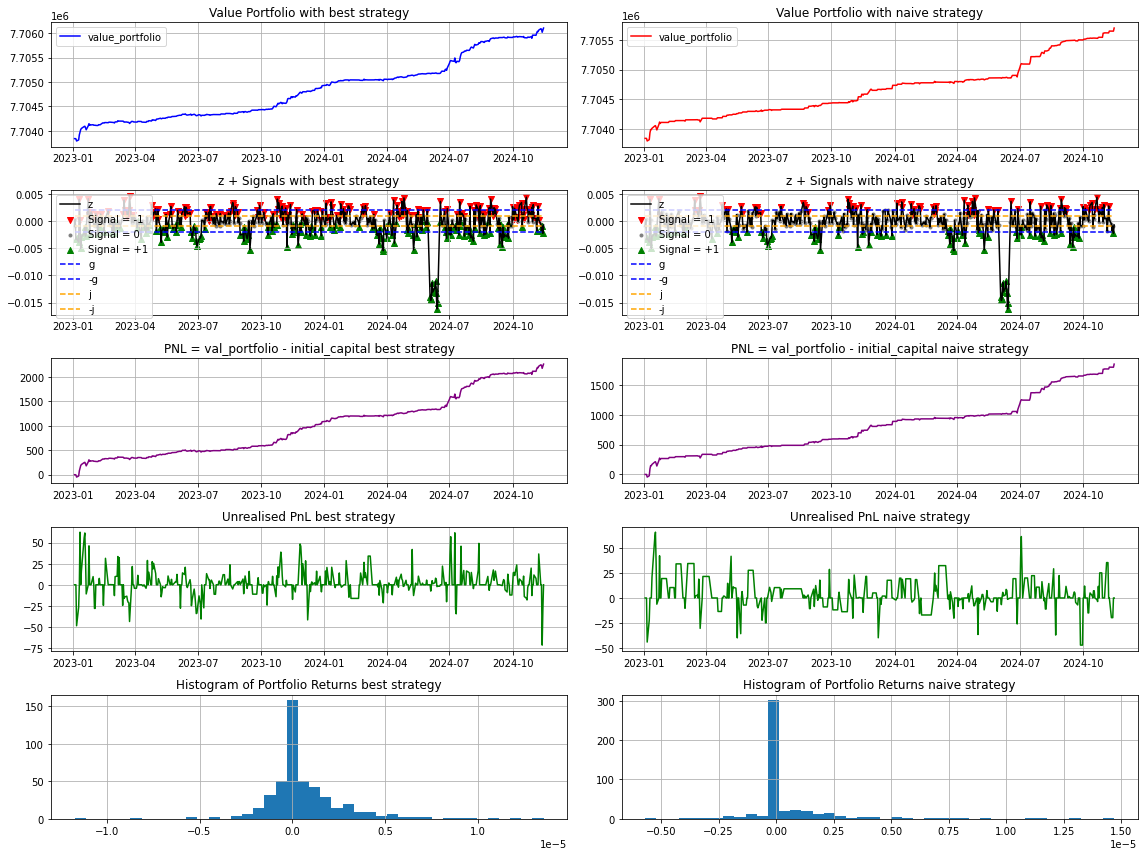

In [135]:

M_best, g_best, j_best = 10, 0.001, 0.00005
best_strategy = backtest(spread, svol_df, FF_df, start_trading_date, end_trading_date, M_best, g_best, j_best, s, tc)
best_strategy.run()

# 1) Filter by signals for best_strategy
df_minus1_best = best_strategy.portfolio[best_strategy.portfolio['signal'] == -1]
df_zero_best   = best_strategy.portfolio[best_strategy.portfolio['signal'] == 0]
df_plus1_best  = best_strategy.portfolio[best_strategy.portfolio['signal'] == 1]
best_strategy.portfolio['cumulative_pnl'] = best_strategy.portfolio['pnl'].cumsum()

# 2) Filter by signals for strategy2
df_minus1_2 = strategy2.portfolio[strategy2.portfolio['signal'] == -1]
df_zero_2   = strategy2.portfolio[strategy2.portfolio['signal'] == 0]
df_plus1_2  = strategy2.portfolio[strategy2.portfolio['signal'] == 1]
strategy2.portfolio['cumulative_pnl'] = strategy2.portfolio['pnl'].cumsum()

fig, ax = plt.subplots(5, 2, figsize=(16, 12))  # 5 rows, 2 columns

############################################
# Plot 1 and 2: Value Portfolio
############################################
ax[0, 0].plot(best_strategy.portfolio['date'], best_strategy.portfolio['value_portfolio'],
              label='value_portfolio', color='blue')
ax[0, 0].legend()
ax[0, 0].set_title('Value Portfolio with best strategy')
ax[0, 0].grid(True)

ax[0, 1].plot(strategy2.portfolio['date'], strategy2.portfolio['value_portfolio'],
              label='value_portfolio', color='red')
ax[0, 1].legend()
ax[0, 1].set_title('Value Portfolio with naive strategy')
ax[0, 1].grid(True)

############################################
# Plot 3 and 4: z + scatter signals
############################################
ax[1, 0].plot(best_strategy.portfolio['date'], best_strategy.portfolio['z'],
              label='z', color='black')
# scatter signals
ax[1, 0].scatter(df_minus1_best['date'], df_minus1_best['z'],
                 marker='v', color='red', label='Signal = -1')
ax[1, 0].scatter(df_zero_best['date'], df_zero_best['z'],
                 marker='.', color='grey', label='Signal = 0')
ax[1, 0].scatter(df_plus1_best['date'], df_plus1_best['z'],
                 marker='^', color='green', label='Signal = +1')
# lines for g1, -g1, j1, -j1
ax[1, 0].plot(best_strategy.portfolio['date'],
              g1 * np.ones(len(best_strategy.portfolio)),
              label='g', color='blue', linestyle='--')
ax[1, 0].plot(best_strategy.portfolio['date'],
              -g1 * np.ones(len(best_strategy.portfolio)),
              label='-g', color='blue', linestyle='--')
ax[1, 0].plot(best_strategy.portfolio['date'],
              j1 * np.ones(len(best_strategy.portfolio)),
              label='j', color='orange', linestyle='--')
ax[1, 0].plot(best_strategy.portfolio['date'],
              -j1 * np.ones(len(best_strategy.portfolio)),
              label='-j', color='orange', linestyle='--')
ax[1, 0].legend()
ax[1, 0].set_title('z + Signals with best strategy')
ax[1, 0].grid(True)

ax[1, 1].plot(strategy2.portfolio['date'], strategy2.portfolio['z'],
              label='z', color='black')
# scatter signals
ax[1, 1].scatter(df_minus1_2['date'], df_minus1_2['z'],
                 marker='v', color='red', label='Signal = -1')
ax[1, 1].scatter(df_zero_2['date'], df_zero_2['z'],
                 marker='.', color='grey', label='Signal = 0')
ax[1, 1].scatter(df_plus1_2['date'], df_plus1_2['z'],
                 marker='^', color='green', label='Signal = +1')
# lines for g2, -g2, j2, -j2
ax[1, 1].plot(strategy2.portfolio['date'],
              g2 * np.ones(len(strategy2.portfolio)),
              label='g', color='blue', linestyle='--')
ax[1, 1].plot(strategy2.portfolio['date'],
              -g2 * np.ones(len(strategy2.portfolio)),
              label='-g', color='blue', linestyle='--')
ax[1, 1].plot(strategy2.portfolio['date'],
              j2 * np.ones(len(strategy2.portfolio)),
              label='j', color='orange', linestyle='--')
ax[1, 1].plot(strategy2.portfolio['date'],
              -j2 * np.ones(len(strategy2.portfolio)),
              label='-j', color='orange', linestyle='--')
ax[1, 1].legend()
ax[1, 1].set_title('z + Signals with naive strategy')
ax[1, 1].grid(True)

############################################
# Plot 5 and 6: PNL
############################################
ax[2, 0].plot(best_strategy.portfolio['date'],
              best_strategy.portfolio['value_portfolio'] - best_strategy.initial_capital,
              label='signal', color='purple')
ax[2, 0].set_title('PNL = val_portfolio - initial_capital best strategy')
ax[2, 0].grid(True)

ax[2, 1].plot(strategy2.portfolio['date'],
              strategy2.portfolio['value_portfolio'] - strategy2.initial_capital,
              label='signal', color='purple')
ax[2, 1].set_title('PNL = val_portfolio - initial_capital naive strategy')
ax[2, 1].grid(True)

############################################
# Plot 7 and 8: Unrealised PNL
############################################
ax[3, 0].plot(best_strategy.portfolio['date'],
              best_strategy.portfolio['u_pnl'],
              label='Unrealised pnl',
              color='green')
ax[3, 0].set_title('Unrealised PnL best strategy')
ax[3, 0].grid(True)

ax[3, 1].plot(strategy2.portfolio['date'],
              strategy2.portfolio['u_pnl'],
              label='Unrealised pnl',
              color='green')
ax[3, 1].set_title('Unrealised PnL naive strategy')
ax[3, 1].grid(True)

############################################
# Plot 9 and 10: Portfolio Return Histogram
############################################
n_bins = 2 * int(np.sqrt(len(best_strategy.portfolio)))
returns1 = best_strategy.portfolio['value_portfolio'].pct_change().dropna()
returns2 = strategy2.portfolio['value_portfolio'].pct_change().dropna()

ax[4, 0].hist(returns1, bins=n_bins)
ax[4, 0].set_title('Histogram of Portfolio Returns best strategy')
ax[4, 0].grid(True)

ax[4, 1].hist(returns2, bins=n_bins)
ax[4, 1].set_title('Histogram of Portfolio Returns naive strategy')
ax[4, 1].grid(True)

plt.tight_layout()
plt.show()



We notice that the histogram of returns is similar to a normal distribution, slightly moved to the right. Whereas we saw for other combinaison that the histrogram of returns was not similar to a known distribution.
The best combination returns density is way more fat tails

## Correlation to Fama French

We try to see how correlated our best trading strategy is to the Fama French model. To do so, we analyse the linear relationship (correlation) of my portfolio's returns with the Fama French factor (market returns...)

In [156]:

import seaborn as sns

filtered_FF_df = FF_df[(FF_df['Date'] >= start_trading_date) & (FF_df['Date'] <= end_trading_date)]

## I add the market return to the FF data because our portoflio returns contains the risk free rate
filtered_FF_df['Mkt'] = filtered_FF_df['Mkt-RF'].values + filtered_FF_df['RF'].values
col = ['return_portfolio','Mkt','Mkt-RF', 'SMB', 'HML', 'RF']
best_strategy.portfolio['return_portfolio'] = best_strategy.portfolio['value_portfolio'].pct_change().dropna()*100 ## we want percentage as the FF data
merged_df = best_strategy.portfolio[['date', 'return_portfolio']].merge(filtered_FF_df, left_on='date', right_on='Date', how='left')[col]
corr = merged_df.corr()

corr

C:\Users\benja\AppData\Local\Temp\ipykernel_16328\711393210.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_FF_df['Mkt'] = filtered_FF_df['Mkt-RF'].values + filtered_FF_df['RF'].values


,return_portfolio,Mkt,Mkt-RF,SMB,HML,RF
return_portfolio,1.000000,-0.030958,-0.031070,0.048163,0.089843,0.049135
Mkt,-0.030958,1.000000,0.999997,0.364671,-0.123358,0.003210
Mkt-RF,-0.031070,0.999997,1.000000,0.364718,-0.123630,0.000929
SMB,0.048163,0.364671,0.364718,1.000000,0.189880,-0.019943
HML,0.089843,-0.123358,-0.123630,0.189880,1.000000,0.119192
RF,0.049135,0.003210,0.000929,-0.019943,0.119192,1.000000


## Commentary

Our trading strategy is not very correlated to the Fama-French factor.
This make sense since the ETFs we are studying (infrastructure companies) and not highly related to those factors, and our trading activity (which is different than just being long) prevent from having a linear relationship with those factors.

This low correlation can be interesting for diversifying a more global trading strategy

## Trade rate , Profitability , and SVOL

SVOL is an ETF that represent short volatility exposure. This should be correlated to our returns/trading rate since a high volatility can imply trading opportunities

We check if the 

In [147]:

svol_df['returns_svol'] = svol_df['adj_close'].pct_change()
filtered_svol_df = svol_df[(svol_df['date'] >= start_trading_date) & (svol_df['date'] <= end_trading_date)]

In [157]:


best_strategy.portfolio['trades_today'] = best_strategy.portfolio['signal'].ne(best_strategy.portfolio['signal'].shift(1)).astype(int)

merged = best_strategy.portfolio[['date', 'trades_today', 'return_portfolio']].merge(
    filtered_svol_df[['date', 'returns_svol']], on='date', how='inner'
)

corr_data = merged[['trades_today', 'returns_svol', 'return_portfolio']].corr()
corr_data


,trades_today,returns_svol,return_portfolio
trades_today,1.000000,0.035760,0.211126
returns_svol,0.035760,1.000000,0.023595
return_portfolio,0.211126,0.023595,1.000000


We can see that the number of trades is correlated to the the portfolio returns. This makes sense since our profit our made from closing a succesful trade.

However, the change of volatility ('returns svol') is not very correlated to the number of trade/ return of the portfolio.

This can be explained as SVOL represents the volatility of the market and our trading strategy is on a specific sector of this market, and the active trading activity prevent from a linear relationship with SVOL.

This low correlation can be very interesting for hedging a trading strategy.

## Show SVOL and trading signals

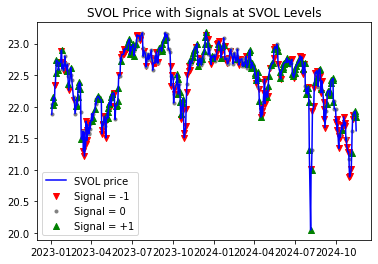

In [146]:

plt.plot(filtered_svol_df['date'], filtered_svol_df['adj_close'], label='SVOL price', color='blue')

df_minus1_best_merged = df_minus1_best[['date']].merge(
    filtered_svol_df[['date', 'adj_close']], on='date', how='left'
)
plt.scatter(
    df_minus1_best_merged['date'],
    df_minus1_best_merged['adj_close'],
    marker='v', color='red', label='Signal = -1'
)

df_zero_best_merged = df_zero_best[['date']].merge(
    filtered_svol_df[['date', 'adj_close']], on='date', how='left'
)
plt.scatter(
    df_zero_best_merged['date'],
    df_zero_best_merged['adj_close'],
    marker='.', color='grey', label='Signal = 0'
)

df_plus1_best_merged = df_plus1_best[['date']].merge(
    filtered_svol_df[['date', 'adj_close']], on='date', how='left'
)
plt.scatter(
    df_plus1_best_merged['date'],
    df_plus1_best_merged['adj_close'],
    marker='^', color='green', label='Signal = +1'
)

plt.title('SVOL Price with Signals at SVOL Levels')
plt.legend()
plt.show()


## Commentary

We plot prices of SVOL ETF and we fit to that the trading signal of our strategy.
First we can see that we trade on almost every day. However we notice that there is a higher density of trades for high volatility, compared to lower volatility. This make sense since a higher volatility means a higher chance to cross the closing threshold, even though it is not that obvious. 